In [47]:
!pip install pyLDAvis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [40]:
import pandas as pd
import numpy as np
import json
from pprint import pprint

import altair as alt
import matplotlib.pyplot as plt

import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models.coherencemodel import CoherenceModel
import pyLDAvis
import pyLDAvis.gensim
from gensim.models import LdaModel
from gensim.models import TfidfModel
import re

pyLDAvis.enable_notebook()

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [26]:
video_df = pd.read_csv('video_transcripts_mix_clean.csv')

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [27]:
video_df['clean_combined'] = video_df[['title_Clean','tags_Clean','description_Clean','Transcript_Blob_Clean']].apply( lambda x: ' '.join(x.dropna()), axis=1)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [28]:
tokenized_vid = [
    [re.sub(r'[^A-Za-z]', '', word) for word in vid.split() if not word.isdigit()]
    for vid in video_df['clean_combined'][:5000].tolist()
]

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
more_stopwords = ['im', 'get', 'dont', 'oh', 'aint', 're', 'th', 'go', 'get', 'let', 'say', 'go', 'great', 'actually', 'really', 'thing', 'also', 'get', 'dont', 'f', 'hi']

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [29]:
bigrams_phrases = gensim.models.Phrases(tokenized_vid, min_count=5, threshold=50)
trigrams_phrases = gensim.models.Phrases(bigrams_phrases[tokenized_vid], threshold=50)

bigrams = gensim.models.phrases.Phraser(bigrams_phrases)
trigrams = gensim.models.phrases.Phraser(trigrams_phrases)

def make_bigrams(texts):
  return (bigrams[vid] for vid in texts)

def make_trigrams(texts):
  return ( trigrams[bigrams[vid]] for vid in texts)

data_bigrams = make_bigrams(tokenized_vid)
data_bigrams_trigrams = make_trigrams(tokenized_vid)

data_bigrams_trigrams_list = list(data_bigrams_trigrams)

print(data_bigrams_trigrams_list[0][0:20])

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


['jadon_sancho', 'magic', 'skill', 'goal', 'footbal_soccer', 'ftbol', 'alemn', 'bundesliga', 'season', 'germani', 'german', 'compil', 'top', 'goal', 'top', 'goal', 'borussia_dortmund', 'best', 'footbal', 'goal']


In [31]:
id2word = corpora.Dictionary(data_bigrams_trigrams_list)
corpus = [id2word.doc2bow(tokens) for tokens in data_bigrams_trigrams_list]

tfidf = TfidfModel(corpus, id2word)

new_corpus = []

low_value = 0.03
words = []
words_missing_in_tfidf = []
for i in range(0, len(corpus)):
  bow = corpus[i]
  low_value_words = []
  tfidf_ids = [id for id, val in tfidf[bow]]
  bow_ids = [id for id, val, in bow]
  low_value_words = [id for id, val in tfidf[bow] if val < low_value]
  drops = low_value_words + words_missing_in_tfidf
  for i in drops:
    words.append(id2word[i])

  words_missing_in_tfidf = [ id for id in bow_ids if id not in tfidf_ids]
  new_bow = [b for b in bow if b[0] not in low_value_words and b[0] not in words_missing_in_tfidf]
  new_corpus.append( new_bow )

corpus = new_corpus

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [ ]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=50,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            eval_every=None)

In [10]:
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
46    -0.447462 -0.131155       1        1  14.974953
47    -0.440915 -0.011053       2        1  14.583698
10    -0.415874 -0.117766       3        1  13.141347
1     -0.395993 -0.129533       4        1  11.273802
18    -0.255310  0.162642       5        1   5.177527
45    -0.196600 -0.117873       6        1   2.876179
48    -0.114001  0.233242       7        1   2.407484
11    -0.078616  0.190615       8        1   1.862909
44    -0.030073  0.088889       9        1   1.712857
23    -0.045707  0.067722      10        1   1.519023
7     -0.082399  0.035587      11        1   1.477234
43    -0.057048  0.093094      12        1   1.428144
25     0.035757  0.016845      13        1   1.396915
26    -0.003404  0.063923      14        1   1.282096
3     -0.045958 -0.019092      15        1   1.275413
39    -0.046214  0.045087      16        1   1.155397
20     0.014312  0.002778      17        1   1.144771
38     0.040358  0.028465      18        1   1.129070
35     0.032463  0.044398      19        1   1.089623
27     0.002279  0.039307      20        1   1.054067
34     0.018423  0.107434      21        1   1.052652
49     0.036312  0.021504      22        1   1.000325
36    -0.012302  0.023158      23        1   0.968125
33    -0.002457 -0.021910      24        1   0.952077
19     0.032623  0.051110      25        1   0.948759
16     0.032846 -0.010197      26        1   0.923478
2      0.093845 -0.029334      27        1   0.831751
30     0.052141  0.011359      28        1   0.824435
0      0.048088  0.014081      29        1   0.800123
40     0.048251  0.003861      30        1   0.708123
41     0.074114 -0.010059      31        1   0.696465
37     0.067134 -0.000971      32        1   0.660824
8      0.091031 -0.027408      33        1   0.637312
13     0.057299  0.011970      34        1   0.608349
32     0.099375 -0.035384      35        1   0.602442
24     0.108720 -0.048652      36        1   0.601195
28     0.088545 -0.030963      37        1   0.585544
5      0.088755 -0.030607      38        1   0.583645
14     0.079403 -0.020716      39        1   0.561717
42     0.079626 -0.021202      40        1   0.530841
21     0.105661 -0.037627      41        1   0.493546
9      0.122273 -0.051165      42        1   0.404415
22     0.138864 -0.057612      43        1   0.319305
29     0.136807 -0.056164      44        1   0.317196
4      0.124936 -0.046298      45        1   0.313412
6      0.137430 -0.056777      46        1   0.303035
12     0.140620 -0.058613      47        1   0.245579
15     0.140079 -0.057379      48        1   0.221596
31     0.148523 -0.060226      49        1   0.174356
17     0.153440 -0.061338      50        1   0.166873, topic_info=               Term          Freq         Total Category  logprob  loglift
32               go  74903.000000  74903.000000  Default   30.000  30.0000
1653           game  12120.000000  12120.000000  Default   29.000  29.0000
31              get  63407.000000  63407.000000  Default   28.000  28.0000
44             know  37496.000000  37496.000000  Default   27.000  27.0000
371             say  21107.000000  21107.000000  Default   26.000  26.0000
...             ...           ...           ...      ...      ...      ...
60    schwarzgelben      0.014461      1.271771  Topic50  -12.109   1.9189
0            action      0.014461    221.539117  Topic50  -12.109  -3.2412
2           alreadi      0.014461     32.477120  Topic50  -12.109  -1.3212
3             anyth      0.014461     57.538475  Topic50  -12.109  -1.8931
4            assist      0.014461    351.688312  Topic50  -12.109  -3.7034

[2226 rows x 6 columns], token_table=      Topic      Freq             Term
term                                  
3698     12  0.979578                a
5408      3  0.176393            aaron
5408     33  0.809331            aaron
6494      1  0.9

In [11]:
lda_20T_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=20,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            eval_every=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [12]:
vis_20T = pyLDAvis.gensim.prepare(lda_20T_model, corpus, id2word)
vis_20T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.393500 -0.080459       1        1  25.553740
10     0.358945 -0.078605       2        1  19.888973
14     0.332332 -0.150442       3        1  12.618902
18     0.226989  0.090264       4        1   8.584585
11     0.110089  0.332301       5        1   7.093977
16     0.052375  0.186908       6        1   6.038895
19     0.020186  0.140116       7        1   3.286181
3      0.042965 -0.032513       8        1   3.066136
17    -0.127297  0.003102       9        1   2.066947
13     0.016229 -0.115557      10        1   1.906041
4     -0.073020 -0.002696      11        1   1.741232
8     -0.123696 -0.004740      12        1   1.609039
2     -0.159212 -0.024481      13        1   1.289934
5     -0.044409 -0.050454      14        1   1.251210
0     -0.138579 -0.027782      15        1   0.968286
9     -0.169210 -0.028328      16        1   0.939494
7     -0.161805 -0.032411      17        1   0.925122
6     -0.181597 -0.041919      18        1   0.442997
15    -0.185412 -0.039859      19        1   0.409927
12    -0.189375 -0.042447      20        1   0.318384, topic_info=            Term          Freq         Total Category  logprob  loglift
32            go  75169.000000  75169.000000  Default  30.0000  30.0000
31           get  63232.000000  63232.000000  Default  29.0000  29.0000
1653        game  12250.000000  12250.000000  Default  28.0000  28.0000
44          know  38280.000000  38280.000000  Default  27.0000  27.0000
74         think  26194.000000  26194.000000  Default  26.0000  26.0000
...          ...           ...           ...      ...      ...      ...
1120     tension     26.920245     69.207468  Topic20  -5.2258   4.8054
2007       drone     29.191971    125.468111  Topic20  -5.1448   4.2915
1106   structure     23.597403     73.035728  Topic20  -5.3575   4.6199
11011  boyfriend     26.152494    224.663418  Topic20  -5.2547   3.5990
4009      planet     17.544829    146.302584  Topic20  -5.6539   3.6287

[1042 rows x 6 columns], token_table=       Topic      Freq            Term
term                                  
3698      14  0.988104               a
6494      12  0.995009              ab
14194     18  0.914914            aber
640        4  0.665856            able
640        5  0.052701            able
...      ...       ...             ...
1888      17  0.016577          youtub
83         5  0.377304  youtub_channel
83         7  0.092546  youtub_channel
83        12  0.526801  youtub_channel
6548      16  0.987362              zu

[1617 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 15, 19, 12, 17, 20, 4, 18, 14, 5, 9, 3, 6, 1, 10, 8, 7, 16, 13])

In [13]:
lda_10T_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=10,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            eval_every=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
vis_10T = pyLDAvis.gensim.prepare(lda_10T_model, corpus, id2word)
vis_10T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
3     -0.369939  0.049163       1        1  37.375596
1     -0.350871  0.135311       2        1  29.016886
7     -0.145959 -0.326548       3        1  14.399369
4      0.095391 -0.061678       4        1   4.047044
8      0.127109  0.085884       5        1   3.845953
0      0.073791  0.104271       6        1   3.533533
6      0.140843 -0.064436       7        1   2.190394
2      0.182490  0.043337       8        1   1.969497
5      0.081723 -0.008380       9        1   1.859015
9      0.165423  0.043075      10        1   1.762714, topic_info=           Term          Freq         Total Category  logprob  loglift
32           go  67655.000000  67655.000000  Default  30.0000  30.0000
31          get  57027.000000  57027.000000  Default  29.0000  29.0000
371         say  18971.000000  18971.000000  Default  28.0000  28.0000
44         know  34308.000000  34308.000000  Default  27.0000  27.0000
1653       game  10520.000000  10520.000000  Default  26.0000  26.0000
...         ...           ...           ...      ...      ...      ...
33         goal    412.500569   1956.046000  Topic10  -4.2078   2.4819
5035    chelsea    177.801228    442.727872  Topic10  -5.0493   3.1260
283        live    126.767117   1565.460318  Topic10  -5.3876   1.5247
677         box    103.049552   1166.625963  Topic10  -5.5948   1.6117
2637  liverpool     85.901776    337.327354  Topic10  -5.7768   2.6705

[596 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
3698       9  0.979448           a
6494       4  0.989319          ab
646        1  0.836184    actually
646        2  0.163574    actually
14921      8  0.983310  adult_swim
...      ...       ...         ...
1176       6  0.005545        year
1888       3  0.354821      youtub
1888       5  0.510597      youtub
1888       7  0.134140      youtub
6548       4  0.988835          zu

[906 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[4, 2, 8, 5, 9, 1, 7, 3, 6, 10])

In [18]:
lda_100T_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=100,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            eval_every=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [19]:
vis_100T = pyLDAvis.gensim.prepare(lda_100T_model, corpus, id2word)
vis_100T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster      Freq
topic                                               
93     0.416496  0.207065       1        1  9.828647
47     0.427575  0.197304       2        1  9.216540
1      0.424156  0.196254       3        1  8.939360
64     0.375453  0.129812       4        1  5.952599
13     0.381877  0.179977       5        1  5.941438
...         ...       ...     ...      ...       ...
69    -0.186308  0.077169      96        1  0.030002
39    -0.189142  0.077247      97        1  0.022028
65    -0.192123  0.077174      98        1  0.021088
96    -0.198735  0.076307      99        1  0.002047
32    -0.198735  0.076307     100        1  0.002039

[100 rows x 5 columns], topic_info=                Term          Freq         Total  Category  logprob  loglift
32                go  74499.000000  74499.000000   Default  30.0000  30.0000
31               get  62809.000000  62809.000000   Default  29.0000  29.0000
44              know  37839.000000  37839.000000   Default  28.0000  28.0000
1653            game  12055.000000  12055.000000   Default  27.0000  27.0000
371              say  21057.000000  21057.000000   Default  26.0000  26.0000
...              ...           ...           ...       ...      ...      ...
25    footbal_soccer      0.000288     67.913925  Topic100 -11.6209  -1.5709
26              forc      0.000288     66.966376  Topic100 -11.6209  -1.5568
27             front      0.000288    866.637018  Topic100 -11.6209  -4.1172
28             ftbol      0.000288     22.952231  Topic100 -11.6209  -0.4860
29            german      0.000288    150.419413  Topic100 -11.6209  -2.3661

[4168 rows x 6 columns], token_table=      Topic      Freq     Term
term                          
3698     49  0.978792        a
5408     22  0.044082    aaron
5408     26  0.943358    aaron
6494     78  0.991909       ab
4142     52  0.984286  abandon
...     ...       ...      ...
3607     11  0.995823  youtube
5954     73  0.639128       yu
9808      2  0.947748    yummy
6548     44  0.995452       zu
3054     65  0.958515      zur

[4305 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[94, 48, 2, 65, 14, 72, 90, 89, 47, 96, 59, 69, 81, 46, 10, 11, 55, 86, 93, 62, 100, 36, 6, 4, 77, 26, 37, 44, 15, 95, 43, 57, 35, 60, 87, 39, 73, 21, 20, 83, 45, 91, 50, 51, 82, 27, 31, 88, 52, 42, 58, 71, 19, 28, 24, 18, 32, 99, 80, 3, 92, 34, 53, 67, 29, 8, 1, 30, 56, 25, 84, 63, 38, 98, 78, 75, 49, 64, 22, 5, 74, 13, 17, 76, 9, 16, 85, 41, 23, 68, 79, 61, 54, 7, 12, 70, 40, 66, 97, 33])

In [12]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=3):

    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

    return model_list, coherence_values

model_list, coherence_values = compute_coherence_values(dictionary=id2word, corpus=corpus, texts=data_bigrams_trigrams_list, start=5, limit=50, step=5)



/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


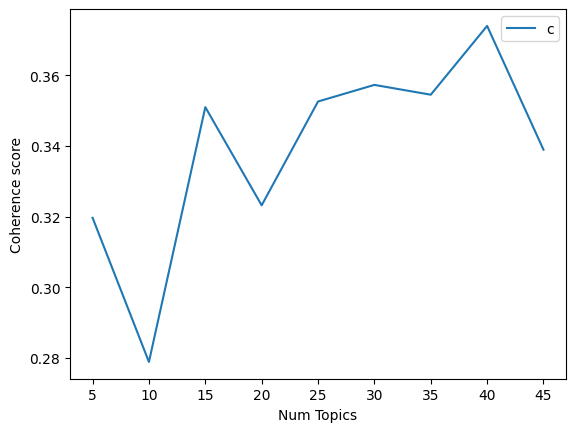

In [14]:
x = range(5, 50, 5)
plt.plot(x, coherence_values)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [54]:
coherence_values2 = []
model_list2 = []
def compute_coherence_values2(dictionary, corpus, texts, limit, start=2, step=3):

    # coherence_values = []
    # model_list = []
    for num_topics in range(start, limit, step):
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=num_topics,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            eval_every=None)
        model_list2.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values2.append(coherencemodel.get_coherence())
        print(num_topics)
    # return model_list, coherence_values

compute_coherence_values2(dictionary=id2word, corpus=corpus, texts=data_bigrams_trigrams_list, start=5, limit=50, step=5)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


5
10
15
20
25
30
35
40
45


/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


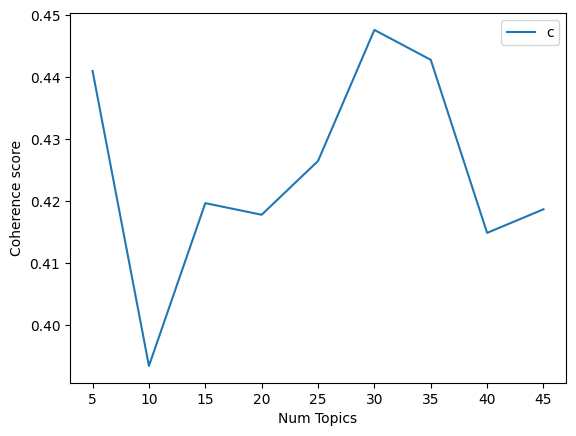

In [69]:
x = range(5, 50, 5)
plt.plot(x, coherence_values2)
plt.xlabel("Num Topics")
plt.ylabel("Coherence score")
plt.legend(("coherence_values"), loc='best')
plt.show()

In [19]:
lda_40T_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                            id2word=id2word,
                                            num_topics=40,
                                            random_state=42,
                                            update_every=1,
                                            chunksize=200,
                                            passes=10,
                                            alpha='auto',
                                            eta='auto',
                                            eval_every=None)

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [44]:
vis_40T = pyLDAvis.gensim.prepare(lda_40T_model, corpus, id2word, n_jobs=1)
vis_40T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.401390  0.110669       1        1  14.656312
10     0.377338  0.054699       2        1  12.740051
33     0.409709  0.090146       3        1  11.073342
14     0.355885 -0.007462       4        1   7.767569
18     0.302406  0.021181       5        1   6.859004
35     0.232200  0.137239       6        1   6.630418
23     0.209192 -0.257314       7        1   5.545342
16     0.017721 -0.157731       8        1   2.616413
30     0.058485 -0.209347       9        1   2.282940
26     0.016363 -0.078265      10        1   2.162881
34     0.055096 -0.099231      11        1   1.874861
19     0.025055 -0.067007      12        1   1.799474
3      0.006266 -0.113244      13        1   1.697398
38    -0.046856 -0.024133      14        1   1.614618
27     0.020405 -0.121027      15        1   1.556056
29    -0.090134  0.025395      16        1   1.497846
5      0.120042  0.157418      17        1   1.415292
31    -0.053644 -0.003582      18        1   1.157189
12    -0.056449 -0.054831      19        1   1.076662
13    -0.070351  0.007140      20        1   1.008497
25    -0.098580  0.026694      21        1   0.986936
11    -0.077211  0.017050      22        1   0.944584
28    -0.115145  0.043702      23        1   0.904835
0     -0.079075  0.014689      24        1   0.902164
36    -0.088863  0.009346      25        1   0.901701
20    -0.075849  0.014284      26        1   0.883929
24    -0.076294  0.018677      27        1   0.798001
4     -0.075342 -0.056339      28        1   0.775076
9     -0.087518  0.032823      29        1   0.770250
32    -0.128343  0.035819      30        1   0.664855
2     -0.115935  0.045003      31        1   0.621448
8     -0.130571  0.040629      32        1   0.567278
37    -0.132936  0.041279      33        1   0.526578
15    -0.138144  0.042179      34        1   0.516754
22    -0.124630  0.032501      35        1   0.515116
7     -0.132676  0.039347      36        1   0.511124
6     -0.120910  0.037074      37        1   0.420588
17    -0.157074  0.050076      38        1   0.290972
21    -0.165638  0.051312      39        1   0.271787
39    -0.169385  0.053141      40        1   0.193856, topic_info=          Term          Freq         Total Category  logprob  loglift
32          go  74978.000000  74978.000000  Default  30.0000  30.0000
31         get  63044.000000  63044.000000  Default  29.0000  29.0000
44        know  38861.000000  38861.000000  Default  28.0000  28.0000
1653      game  12491.000000  12491.000000  Default  27.0000  27.0000
371        say  21247.000000  21247.000000  Default  26.0000  26.0000
...        ...           ...           ...      ...      ...      ...
8380   gardner      1.006526      2.256462  Topic40  -8.0160   5.4385
8401      kirk      1.005356      2.255292  Topic40  -8.0172   5.4379
8209  talented      4.419935     23.266301  Topic40  -6.5364   4.5849
5555     voice     36.217902    209.187260  Topic40  -4.4330   4.4921
172   describe     14.906378    181.590290  Topic40  -5.3207   3.7458

[1874 rows x 6 columns], token_table=      Topic      Freq            Term
term                                 
3698     40  0.974799               a
5408      6  0.045525           aaron
5408     32  0.933257           aaron
6494     32  0.991002              ab
640       3  0.129950            able
...     ...       ...             ...
1888     30  0.997181          youtub
83       31  0.996570  youtub_channel
2133     36  0.964378              yt
8922      9  0.993130          zombie
6548     23  0.991275              zu

[2790 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 34, 15, 19, 36, 24, 17, 31, 27, 35, 20, 4, 39, 28, 30, 6, 32, 13, 14, 26, 12, 29, 1, 37, 21, 25, 5, 10, 33, 3, 9, 38, 16, 23, 8, 7, 18, 22, 40])

In [76]:
vis_30T = pyLDAvis.gensim.prepare(model_list2[5], corpus, id2word, n_jobs=1)
vis_30T

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.428190 -0.032997       1        1  21.618183
10     0.390559 -0.075483       2        1  18.018362
14     0.392447 -0.102280       3        1  12.540667
23     0.296118 -0.122426       4        1   7.085348
26     0.220934  0.106687       5        1   6.930247
11     0.125885  0.370344       6        1   5.313479
16     0.049211  0.068370       7        1   2.522039
19    -0.031980  0.015029       8        1   1.945745
18     0.015932  0.167519       9        1   1.926388
22     0.045147 -0.068123      10        1   1.880325
21    -0.046030  0.076588      11        1   1.865179
3     -0.005040  0.019030      12        1   1.758884
29    -0.109080 -0.040635      13        1   1.548576
7     -0.067764 -0.017415      14        1   1.479168
5     -0.060992 -0.003907      15        1   1.363249
6     -0.075587 -0.017759      16        1   1.307149
20    -0.065626 -0.026159      17        1   1.232087
25    -0.109395 -0.038582      18        1   1.132857
28    -0.112340 -0.035200      19        1   1.114987
27    -0.071279 -0.059027      20        1   0.952953
4     -0.098111 -0.017247      21        1   0.948611
24    -0.049198  0.049821      22        1   0.886070
0     -0.100819 -0.009574      23        1   0.831335
9     -0.118863 -0.014946      24        1   0.819513
12    -0.117405 -0.005124      25        1   0.777910
17    -0.136380 -0.030143      26        1   0.604902
13    -0.127098 -0.045087      27        1   0.505871
2     -0.146996 -0.025257      28        1   0.407678
15    -0.157124 -0.041749      29        1   0.357760
8     -0.157316 -0.044265      30        1   0.324478, topic_info=       Term          Freq         Total Category  logprob  loglift
32       go  74617.000000  74617.000000  Default  30.0000  30.0000
31      get  62823.000000  62823.000000  Default  29.0000  29.0000
1653   game  12252.000000  12252.000000  Default  28.0000  28.0000
44     know  38070.000000  38070.000000  Default  27.0000  27.0000
333    play   9178.000000   9178.000000  Default  26.0000  26.0000
...     ...           ...           ...      ...      ...      ...
7020  ingam      8.497622      9.736073  Topic30  -6.3978   5.5947
5501  gamer     91.098725    131.591116  Topic30  -4.0257   5.3630
3484    mod     96.963438    269.086510  Topic30  -3.9633   4.7100
7375   vlog    167.613746    931.295513  Topic30  -3.4159   4.0158
6066   mega     14.126875     33.001779  Topic30  -5.8895   4.8822

[1470 rows x 6 columns], token_table=       Topic      Freq        Term
term                              
6494      21  0.989946          ab
640        3  0.282719        able
640       27  0.715506        able
10496     29  0.939354   abonnetoi
1834       1  0.853870  absolutely
...      ...       ...         ...
3607       1  0.043801     youtube
3607       3  0.952682     youtube
8922      10  0.992602      zombie
3911       2  0.992894        zone
6548      19  0.993294          zu

[2204 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 11, 15, 24, 27, 12, 17, 20, 19, 23, 22, 4, 30, 8, 6, 7, 21, 26, 29, 28, 5, 25, 1, 10, 13, 18, 14, 3, 16, 9])